## AuxTel AzEl offsets - 26-May-21

In this notebook, investigate az-el offsets from 25-May-21\
This is going to analyze a figure 8 of exposures

In [6]:
import sys, time, os, asyncio, glob

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle as pkl
import pandas as pd
import astropy.io.fits as pf
from astropy.time import Time, TimeDelta
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from lsst.daf.butler import Butler as gen3Butler
from lsst.daf.persistence import Butler as gen2Butler
from lsst_efd_client import EfdClient
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

In [7]:
# Get EFD client
#client = EfdClient('ldf_stable_efd')
client = EfdClient('summit_efd')

def merge_packed_time_series(packed_dataframe, base_field, stride=1, 
                             ref_timestamp_col="cRIO_timestamp", internal_time_scale="tai"):
    """Select fields that are time samples and unpack them into a dataframe.
            Parameters
            ----------
            packedDF : `pandas.DataFrame`
                packed data frame containing the desired data
            base_field :  `str`
                Base field name that will be expanded to query all
                vector entries.
            stride : `int`, optional
                Only use every stride value when unpacking.  Must be a factor
                of the number of packed values.
                (1 by default)
            ref_timestamp_col : `str`, optional
                Name of the field name to use to assign timestamps to unpacked
                vector fields (default is 'cRIO_timestamp').
            internal_time_scale : `str`, optional
                Time scale to use when converting times to internal formats
                ('tai' by default). Equivalent to EfdClient.internal_scale
        Returns
            -------
            result : `pandas.DataFrame`
                A `pandas.DataFrame` containing the results of the query.
            """
    
    packed_fields = [k for k in packed_dataframe.keys() if k.startswith(base_field)]
    packed_fields = sorted(packed_fields, key=lambda k: int(k[len(base_field):]))  # sort by pack ID
    npack = len(packed_fields)
    if npack%stride != 0:
        raise RuntimeError(f"Stride must be a factor of the number of packed fields: {stride} v. {npack}")
    packed_len = len(packed_dataframe)
    n_used = npack//stride   # number of raw fields being used
    output = np.empty(n_used*packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col][0])
    
    if packed_len == 1:
        dt = 0
    else:
        dt = (packed_dataframe[ref_timestamp_col][1] - packed_dataframe[ref_timestamp_col][0])/npack
    for i in range(0, npack, stride):
        i0 = i//stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i*dt
     
    timestamps = Time(times, format='unix', scale=internal_time_scale).datetime64
    return pd.DataFrame({base_field:output, "times":times}, index=timestamps)

# This makes the plots more readable
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [8]:
# Gen3 butler
dayObs = 20210525
REPO_DIR = '/repo/main'
butler_g3 = gen3Butler(REPO_DIR, collections="LATISS/raw/all")

2021052500154 az_fit [-1.49649409e-02 -4.00443483e+01] el_fit [-2.32043133e-03  7.80544962e+01]
2021052500155 az_fit [-1.50634924e-02 -4.02398160e+01] el_fit [-2.32136917e-03  7.80521131e+01]
2021052500156 az_fit [-1.47814706e-02 -4.05983052e+01] el_fit [-2.34747442e-03  7.80171580e+01]
2021052500157 az_fit [-1.47590063e-02 -4.08057770e+01] el_fit [-2.35393313e-03  7.79564438e+01]
2021052500158 az_fit [-1.48063072e-02 -4.08808345e+01] el_fit [-2.36134886e-03  7.79235634e+01]
2021052500159 az_fit [-1.46526477e-02 -4.10868472e+01] el_fit [-2.35399672e-03  7.78626633e+01]
2021052500160 az_fit [-1.45653673e-02 -4.11606898e+01] el_fit [-2.38225561e-03  7.78296346e+01]
2021052500161 az_fit [-1.45676607e-02 -4.13649037e+01] el_fit [-2.38656157e-03  7.78241807e+01]


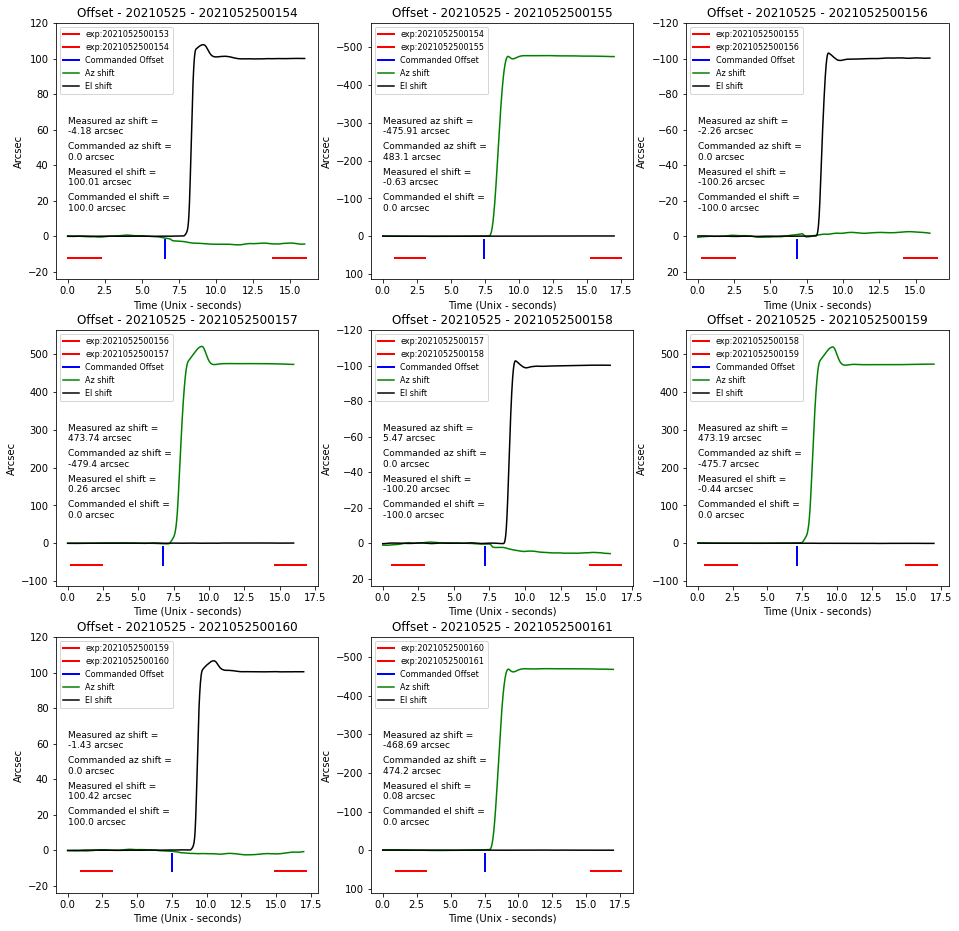

In [9]:
# First get all of the tracking data

firstExpId = 2021052500153
lastExpId = 2021052500161
charVisits = {}
plotCounter = 1
fig = plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=0.2, wspace=0.2)

for expId in range(firstExpId, lastExpId+1):
    charVisit = {}
    if expId == firstExpId:
        expId1 = expId
        mData1 = butler_g3.get('raw.metadata', detector=0, exposure=expId1)
        exp1Start = Time(mData1['DATE-BEG'],scale='tai') - TimeDelta(4.0, format = 'sec')
    else:
        expId1 = expId-1
        mData1 = butler_g3.get('raw.metadata', detector=0, exposure=expId1)
        exp1Start = Time(mData1['DATE-BEG'],scale='tai')
    exp1End = Time(mData1['DATE-END'],scale='tai')
    expId2 = expId
    mData2 = butler_g3.get('raw.metadata', detector=0, exposure=expId2)
    exp2Start = Time(mData2['DATE-BEG'],scale='tai')
    exp2End = Time(mData2['DATE-END'],scale='tai')
    charVisit['mData'] = mData2
    # These are for finding the timestamps of the offset event
    offsets = await client.select_time_series("lsst.sal.ATPtg.command_offsetAzEl", ['*'],
                                          exp1Start, exp2End)
    if len(offsets) > 0:
        offsetTime = Time(offsets.index[0],scale='tai')
        commandedAzShift = offsets.values[0][0] / np.cos(mData1['ELSTART'] * np.pi / 180.0)
        commandedElShift = offsets.values[0][1]
        # Now get the mount data
        mount_position = await client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", ['*'],
                                              exp1Start, exp2End)
        az = merge_packed_time_series(mount_position, 'azimuthCalculatedAngle', stride=1)
        el = merge_packed_time_series(mount_position, 'elevationCalculatedAngle', stride=1)

        # Calculate the tracking shift
        az_vals = np.array(az.values.tolist())[:,0]
        el_vals = np.array(el.values.tolist())[:,0]
        times = np.array(az.values.tolist())[:,1] - 35.84 ## WHY??
        zeroTime = times[0]
        times -= zeroTime
        #shiftIndex = np.where(times>offsetTime.tai.unix-zeroTime)[0][0]
        valsPerSecond = 100
        n1 = np.where(times>exp1Start.tai.unix-zeroTime)[0][0] # Start of first exposure
        n2 = np.where(times>offsetTime.tai.unix-zeroTime)[0][0] # Time of commanded offset
        n3 = np.where(times>exp2Start.tai.unix-zeroTime)[0][0] # Start of second exposure
        n4 = len(times)

        # Fit the tracking before the offset with a quadratic
        az_vals_fit = az_vals[n1:n2]
        el_vals_fit = el_vals[n1:n2]
        times_fit = times[n1:n2]
        az_fit = np.polyfit(times_fit, az_vals_fit, 1)
        el_fit = np.polyfit(times_fit, el_vals_fit, 1)
        print(expId, "az_fit", az_fit, "el_fit", el_fit)
        #az_model = az_fit[0] * times * times + az_fit[1] * times + az_fit[2]
        #el_model = el_fit[0] * times * times + el_fit[1] * times + el_fit[2]
        az_model = az_fit[0] * times + az_fit[1]
        el_model = el_fit[0] * times  + el_fit[1]

        # Apply this model and calculate the departure from the model after the shift
        az_error = (az_vals - az_model) * 3600
        el_error = (el_vals - el_model) * 3600

        az_shift = np.mean(az_error[n3:n4])
        el_shift = np.mean(el_error[n3:n4])
        if abs(el_shift) > abs(az_shift):
            ymax = 10.0 * int(el_shift / 10.0) * 1.2
        else:
            ymax = 10.0 * int(az_shift / 10.0) * 1.2
        ymin = -ymax / 5.0
        ymid = ymax * 0.6
        plt.subplot(3, 3, plotCounter)
        plt.title(f"Offset - {dayObs} - {expId}", fontsize = 12)
        plt.plot([exp1Start.tai.unix-zeroTime, exp1End.tai.unix-zeroTime], [ymin*0.5,ymin*0.5], color='red', lw=2.0, label=f"exp:{expId1}")
        plt.plot([exp2Start.tai.unix-zeroTime, exp2End.tai.unix-zeroTime], [ymin*0.5,ymin*0.5], color='red', lw=2.0, label=f"exp:{expId2}")
        plt.plot([offsetTime.tai.unix-zeroTime,offsetTime.tai.unix-zeroTime], [ymin*0.5, ymin*0.1], color='blue', lw=2.0, label="Commanded Offset")
        plt.plot(times, az_error, color='green', label="Az shift")
        plt.text(times[0], ymid*0.8, f"Measured az shift = \n{az_shift:.2f} arcsec", fontsize=9)
        plt.text(times[0], ymid*0.6, f"Commanded az shift = \n{commandedAzShift:.1f} arcsec", fontsize=9)
        plt.plot(times, el_error, color='black', label="El shift")
        plt.text(times[0], ymid*0.4, f"Measured el shift = \n{el_shift:.2f} arcsec", fontsize=9)
        plt.text(times[0], ymid*0.2, f"Commanded el shift = \n{commandedElShift:.1f} arcsec", fontsize=9)
        plt.ylabel("Arcsec")
        plt.xlabel("Time (Unix - seconds)")
        plt.legend(loc='upper left', fontsize=8)
        plt.ylim(ymin, ymax)
        plotCounter += 1
        
    else:
        commandedAzShift = 0.0
        commandedElShift = 0.0
        az_shift = 0.0
        el_shift = 0.0
    charVisit['commandedAzShift'] = commandedAzShift
    charVisit['commandedElShift'] = commandedElShift
    charVisit['az_shift'] = az_shift
    charVisit['el_shift'] = el_shift
    charVisits[f"{expId}"] = charVisit

plt.savefig(f"/project/cslage/AuxTel/offsets/Offsets_{expId1}_{expId2}_25May21.pdf")

In [10]:
# Get the raw quickLook data.  Only Gen2 works for now
REPO_DIR = '/project/shared/auxTel/rerun/quickLook'
gen2_butler = gen2Butler(REPO_DIR)
dayObs = '2021-05-25'

In [11]:
# Now get the image data
charConfig = CharacterizeImageConfig()
charConfig.doMeasurePsf = False#True
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = True   
charConfig.detection.minPixels = 500
charTask = CharacterizeImageTask(config=charConfig)

for expId in range(firstExpId, lastExpId+1):
    charVisit = charVisits[f"{expId}"]
    exp = gen2_butler.get('quickLookExp', detector=0, expId=expId)
    charResult = charTask.run(exp)
    sourceCatalog = charResult.sourceCat
    maxFlux = np.nanmax(sourceCatalog['base_CircularApertureFlux_3_0_instFlux'])
    selectBrightestSource = sourceCatalog['base_CircularApertureFlux_3_0_instFlux'] > maxFlux * 0.99
    brightestSource = sourceCatalog.subset(selectBrightestSource)
    brightestCentroid = (brightestSource['base_SdssCentroid_x'][0], \
                         brightestSource['base_SdssCentroid_y'][0])
    brightCatalog = sourceCatalog.subset(sourceCatalog['base_CircularApertureFlux_3_0_instFlux'] > maxFlux * 0.0001)
    print(f"expId:{expId}. Found {len(sourceCatalog)} sources, {len(brightCatalog)} bright sources")
    print(f"Brightest centroid at {brightestCentroid}")
    charVisit['exp'] = exp
    charVisit['brightestCentroid'] = brightestCentroid
    charVisit['brightCatalog'] = brightCatalog
    charVisits[f"{expId}"] = charVisit


Ignoring translator header fixup of LATISS AT_O_20210525_000153: 'MJD-OBS not found'


expId:2021052500153. Found 7 sources, 7 bright sources
Brightest centroid at (1754.8785619811847, 1821.8242287330297)


Ignoring translator header fixup of LATISS AT_O_20210525_000154: 'MJD-OBS not found'


expId:2021052500154. Found 5 sources, 5 bright sources
Brightest centroid at (734.4330370062224, 1603.917623881697)


Ignoring translator header fixup of LATISS AT_O_20210525_000155: 'MJD-OBS not found'


expId:2021052500155. Found 3 sources, 3 bright sources
Brightest centroid at (505.3670762589491, 2629.714908876476)


Ignoring translator header fixup of LATISS AT_O_20210525_000156: 'MJD-OBS not found'


expId:2021052500156. Found 7 sources, 7 bright sources
Brightest centroid at (1529.444641246469, 2854.1332372340726)


Ignoring translator header fixup of LATISS AT_O_20210525_000157: 'MJD-OBS not found'


expId:2021052500157. Found 6 sources, 6 bright sources
Brightest centroid at (1757.6770908582628, 1825.3816397502264)


Ignoring translator header fixup of LATISS AT_O_20210525_000158: 'MJD-OBS not found'


expId:2021052500158. Found 8 sources, 8 bright sources
Brightest centroid at (2779.1353810036844, 2062.9864363506995)


Ignoring translator header fixup of LATISS AT_O_20210525_000159: 'MJD-OBS not found'


expId:2021052500159. Found 8 sources, 8 bright sources
Brightest centroid at (3011.0777296224505, 1032.748535649635)


Ignoring translator header fixup of LATISS AT_O_20210525_000160: 'MJD-OBS not found'


expId:2021052500160. Found 4 sources, 4 bright sources
Brightest centroid at (1996.6903926820596, 794.730262404742)


Ignoring translator header fixup of LATISS AT_O_20210525_000161: 'MJD-OBS not found'


expId:2021052500161. Found 6 sources, 6 bright sources
Brightest centroid at (1747.6826127983838, 1813.8008561705917)


In [12]:
mData = charVisits[str(firstExpId)]['mData']
pointingCoords = SkyCoord(ra=mData['RASTART']*u.degree, dec=mData['DECSTART']*u.degree)
pointingAltaz = AltAz(az=mData['AZSTART']*u.degree, alt=mData['ELSTART']*u.degree)


In [13]:
# Set Cerro Pachon location and observation time
mData = charVisits[str(firstExpId)]['mData']
location = EarthLocation.from_geodetic(lon=mData['OBS-LONG']*u.deg,
                                       lat=mData['OBS-LAT']*u.deg,
                                       height=mData['OBS-ELEV']*u.m)

utcoffset = -4*u.hour  
time = Time(mData['DATE-BEG']) + utcoffset
time.format = 'iso'

In [14]:
sinTheta =  np.cos(location.lat.rad) / np.cos(pointingCoords.dec.rad) * np.sin(pointingAltaz.az.rad)
theta = Angle(np.arcsin(sinTheta)*180.0 / np.pi * u.deg)
print(theta.deg)

-36.42138560573006


-113.57 -77.14861439426994


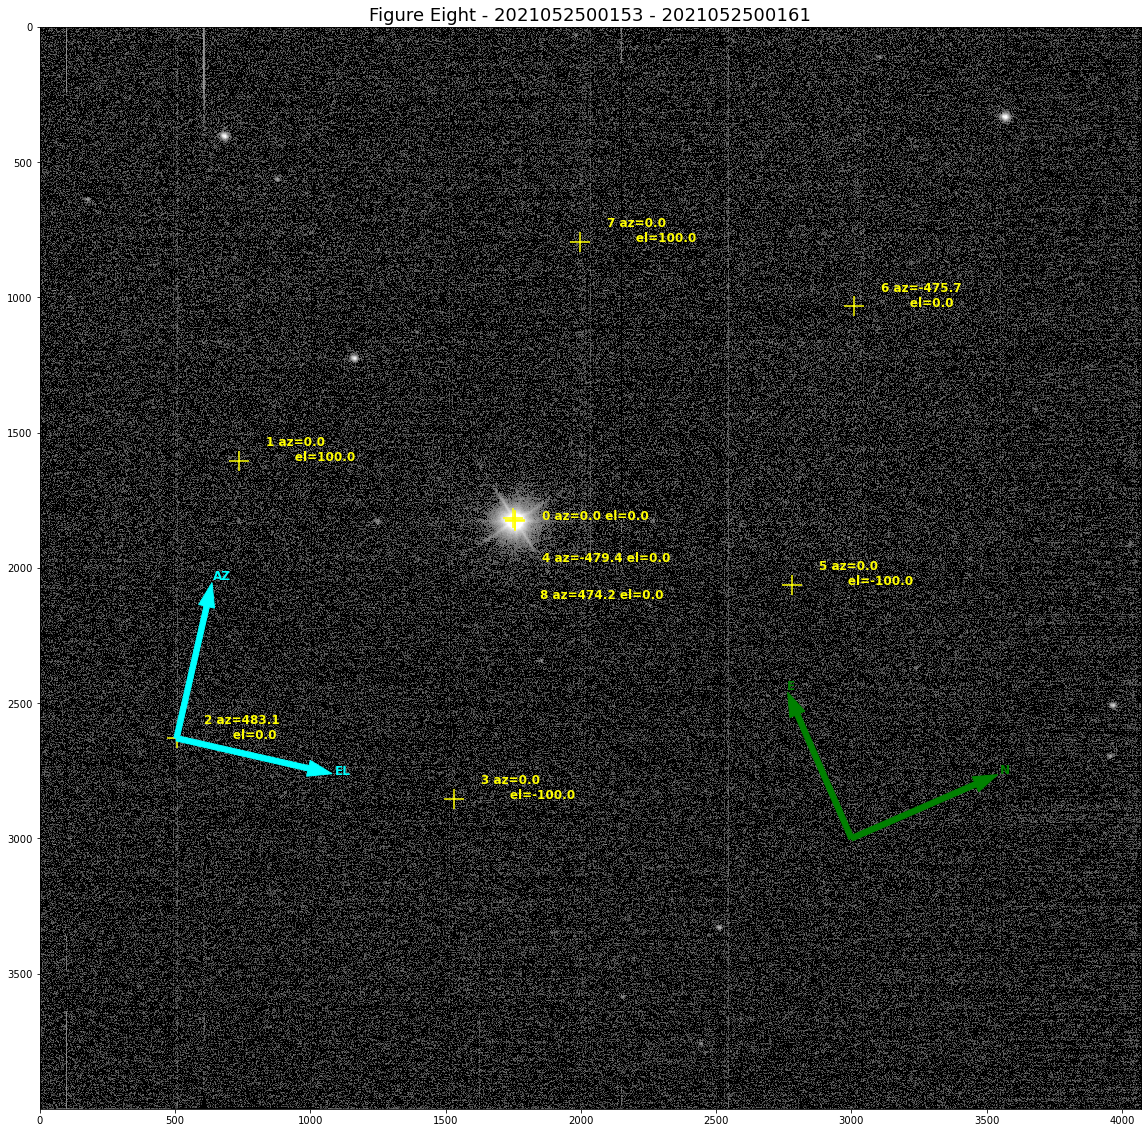

In [15]:
# Plot the images
Ncenter = (3000,3000)
NcenterAzEl = charVisits['2021052500155']['brightestCentroid']#(1000,3000)
Nlength = 500.0
Nlabel = 600.0
yShift = 150.0
shiftCounter = 0
plt.figure(figsize=(16,16))

for expId in range(firstExpId, lastExpId+1):
    seqNo = expId - firstExpId
    charVisit = charVisits[f"{expId}"]
    plt.subplot(1,1,1)
    plt.title(f"Figure Eight - {firstExpId} - {lastExpId}",fontsize=18)
    plt.scatter([charVisit['brightestCentroid'][0]],[charVisit['brightestCentroid'][1]] \
                ,color='yellow', marker='+', s=400)
    if seqNo == 0:
        arr = charVisit['exp'].image.array
        arr = np.clip(arr, 1, 100000) # This image has some negative values, and this removes them
        img = plt.imshow(arr, norm=LogNorm(vmin=1, vmax=1000),  interpolation='Nearest', cmap='gray')

        cat = charVisit['brightCatalog']
        rotpa = Angle(-113.57*u.deg)#  Header wrong for these images  Angle(charVisit['mData']['ROTPA']*u.deg)
        plt.arrow(Ncenter[0],Ncenter[1], -Nlength*np.sin(rotpa), Nlength*np.cos(rotpa),\
            color='green', width = 20)
        plt.text(Ncenter[0]-Nlabel*np.sin(rotpa),Ncenter[1]+Nlabel*np.cos(rotpa), 'N', \
            color='green', fontsize=12, weight='bold')
        plt.arrow(Ncenter[0],Ncenter[1], Nlength*np.cos(rotpa), Nlength*np.sin(rotpa),\
            color='green', width = 20)
        plt.text(Ncenter[0]+Nlabel*np.cos(rotpa),Ncenter[1]+Nlabel*np.sin(rotpa), 'E', \
            color='green', fontsize=12, weight='bold')

        rotAzEl = rotpa - theta
        print(rotpa.deg, rotAzEl.deg)
        plt.arrow(NcenterAzEl[0],NcenterAzEl[1], -Nlength*np.sin(rotAzEl), Nlength*np.cos(rotAzEl),\
            color='cyan', width = 20)
        plt.text(NcenterAzEl[0]-Nlabel*np.sin(rotAzEl),NcenterAzEl[1]+Nlabel*np.cos(rotAzEl), 'EL', \
            color='cyan', fontsize=12, weight='bold')
        plt.arrow(NcenterAzEl[0],NcenterAzEl[1], Nlength*np.cos(rotAzEl), Nlength*np.sin(rotAzEl),\
            color='cyan', width = 20)
        plt.text(NcenterAzEl[0]+Nlabel*np.cos(rotAzEl),NcenterAzEl[1]+Nlabel*np.sin(rotAzEl), 'AZ', \
            color='cyan', fontsize=12, weight='bold')

    if seqNo in [0,4,8]:
        plt.text((charVisit['brightestCentroid'][0]+100), \
                 (charVisit['brightestCentroid'][1] + shiftCounter*yShift), \
                 f"{seqNo} az={charVisit['commandedAzShift']:.1f} el={charVisit['commandedElShift']:.1f}", \
                 color='yellow', fontsize=12, weight='bold')
        
        shiftCounter += 1
    else:
        plt.text((charVisit['brightestCentroid'][0]+100), \
                 (charVisit['brightestCentroid'][1]), \
                 f"{seqNo} az={charVisit['commandedAzShift']:.1f}\n       el={charVisit['commandedElShift']:.1f}", \
                 color='yellow', fontsize=12, weight='bold')
    #plt.xlim(0,4000)
    #plt.ylim(4000,0)
plt.tight_layout(h_pad=1)
#plt.savefig(f"/project/cslage/AuxTel/offsets/Offsets_Figure_Eight_{firstExpId}_{lastExpId}_25May21.pdf")

In [ ]:
mData['OBJECT']

In [ ]:
charVisits['2021052500170']['mData']['ROTPA']

In [ ]:
# Plot the images
plt.figure(figsize=(16,16))
expId = 2021052500170
#charVisit = charVisits[f"{expId}"]
plt.subplot(1,1,1)
plt.title(f"Image - {expId}",fontsize=18)
exp = gen2_butler.get('quickLookExp', detector=0, expId=expId)
arr = exp.image.array
arr = np.clip(arr, 1, 100000) # This image has some negative values, and this removes them
img = plt.imshow(arr, norm=LogNorm(vmin=1, vmax=1000),  interpolation='Nearest', cmap='gray')
#cat = charVisit['brightCatalog']
plt.scatter(cat['base_SdssCentroid_x'],cat['base_SdssCentroid_y']\
            ,color='red', marker='x')
#plt.scatter([charVisit['brightestCentroid'][0]],[charVisit['brightestCentroid'][1]] \
#            ,color='green', marker='+', s=200)
colorbar(img)
plt.legend()
#plt.ylim(0,4000)
plt.tight_layout(h_pad=1)
#plt.savefig(f"/project/cslage/AuxTel/offsets/Offsets_{expIds[0]}_{expIds[1]}_{expIds[2]}_{expIds[3]}_16Apr21.pdf")

In [ ]:
cat = charVisits[str(expId)]['brightCatalog']

In [ ]:
cat['base_CircularApertureFlux_3_0_instFlux']

In [ ]:
test = cat.asAstropy()
test.keep_columns(['base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_CircularApertureFlux_3_0_instFlux'])
print(test)

In [ ]:
test.sort('base_CircularApertureFlux_3_0_instFlux', reverse=True)
print(test)

In [ ]:
# Now get the image data
charConfig = CharacterizeImageConfig()
charConfig.doMeasurePsf = False#True
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = True   
charConfig.detection.minPixels = 500
charTask = CharacterizeImageTask(config=charConfig)
expId = 2021052500170
exp = gen2_butler.get('quickLookExp', detector=0, expId=expId)
charResult = charTask.run(exp)
sourceCatalog = charResult.sourceCat
maxFlux = np.nanmax(sourceCatalog['base_CircularApertureFlux_3_0_instFlux'])
selectBrightestSource = sourceCatalog['base_CircularApertureFlux_3_0_instFlux'] > maxFlux * 0.99
brightestSource = sourceCatalog.subset(selectBrightestSource)
brightestCentroid = (brightestSource['base_SdssCentroid_x'][0], \
                     brightestSource['base_SdssCentroid_y'][0])
brightCatalog = sourceCatalog.subset(sourceCatalog['base_CircularApertureFlux_3_0_instFlux'] > maxFlux * 0.0001)


In [ ]:
cat = brightCatalog

In [ ]:
cat['base_CircularApertureFlux_3_0_instFlux']

In [ ]:
test = cat.asAstropy()
test.keep_columns(['base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_CircularApertureFlux_3_0_instFlux'])
#test.remove_row(10)
print(test)

In [ ]:
test.sort('base_CircularApertureFlux_3_0_instFlux', reverse=True)
print(test)

In [18]:
expId = 2021052500161
mData = butler_g3.get('raw.metadata', detector=0, exposure=expId)
print(mData['DATE-BEG'])
expId = 2021052500170
mData = butler_g3.get('raw.metadata', detector=0, exposure=expId)
print(mData['DATE-BEG'])

2021-05-25T23:57:30.911
2021-05-26T00:01:50.859
